In [22]:
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [5]:
SOURCE_DIR = "C:/database/StyleGanv1"


In [23]:
image = Image.open(os.path.join(SOURCE_DIR, '000000.png'))
image2 = cv2.imread(os.path.join(SOURCE_DIR, '000000.png'), 0)

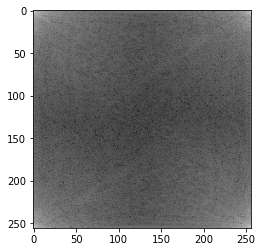

In [26]:
img_c2 = np.fft.fft2(image2)
plt.imshow(np.log(1+np.abs(img_c2)), cmap = 'gray')

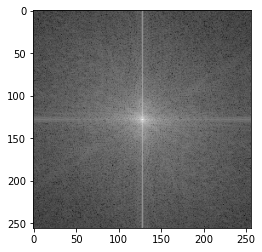

In [27]:
img_c3 = np.fft.fftshift(img_c2)
plt.imshow(np.log(1+np.abs(img_c3)), cmap = 'gray')